# Проект - Определение стоимости автомобилей

### Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
- Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.


- Критерии, которые важны заказчику:
    1. качество предсказания;
    2. время обучения модели;
    3. время предсказания модели.
    4. Значение метрики RMSE должно быть меньше 2500.

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

**При необходимости раскомментируйте установите следующие библиотеки ⇩**

In [1]:
#!pip install xgboost
#!pip install catboost
#!pip install lightgbm

In [2]:
#стандартные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#импортируем модели
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

#предобработка данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

#метрика
from sklearn.metrics import mean_squared_error

#тестируем HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#настройка для sns
sns.set(rc={'figure.figsize':(5, 6)})

****

# 1. Знакомство с данными

In [3]:
#загружаем данные
data = pd.read_csv('autos.csv')

In [4]:
#первые пять строк
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
#размер таблицы
data.shape

(354369, 16)

In [6]:
#общая информаци
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
#считаем пропуски
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
#считаем дубликаты
data.duplicated().sum()

4

In [9]:
#названия столбцов
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

- Пропуски в столбцах как-то корректно восстановить не представляется возможным, но их очень много, поэтому предлагаю их оставить и создать для них отдельные категории

In [10]:
#заменяем пропуски
undefined_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

for column in undefined_columns:
    data[column] = data[column].fillna('undefined')

In [11]:
#считаем пропуски
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [12]:
#удалим дубликаты пересбросим индексы
data = data.drop_duplicates().reset_index(drop=True)

In [13]:
#считаем дубликаты
data.duplicated().sum()

0

In [14]:
#размер
data.shape

(354365, 16)

**Вывод:**
- Изучили таблицу, всего 354.365 тыс. объектов и 16 признаков для каждого
- Заменили пропущенные значения, создав категорию не определено, так как корректо восстановить их не получится, а если удалить останется слишком маленькая выборка
- Удалили дубликаты

# 2. Исследовательский анализ данных

In [15]:
#дата скачивания анкеты из базы
data['DateCrawled'].min(), data['DateCrawled'].max()

('2016-03-05 14:06:22', '2016-04-07 14:36:58')

- **Смотрим интервал скачиваний анкет, данные скачаны за 1 месяц**

In [16]:
#даты создания анкет
data['DateCreated'].min(), data['DateCreated'].max()

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

- **Анкеты на автомобили за 2 года с 2014 по 2016 год**

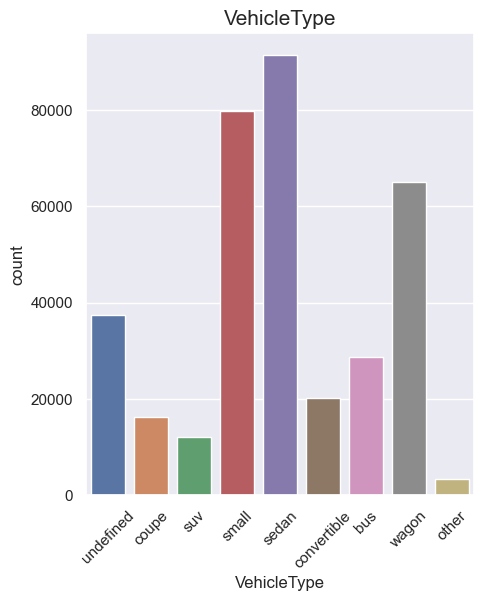

In [17]:
#тип кузова автомобиля
sns.countplot(x=data['VehicleType'])
plt.title('VehicleType', fontsize=15)
plt.xticks(rotation=45)
plt.show()

- **Смотрим какие автомобили какого типа продаются в сервисе, самый распространенный тип это седан, за ним категория small, на 3 месте категория wagon, так же можно заметить коммерческий тип авто - bus**

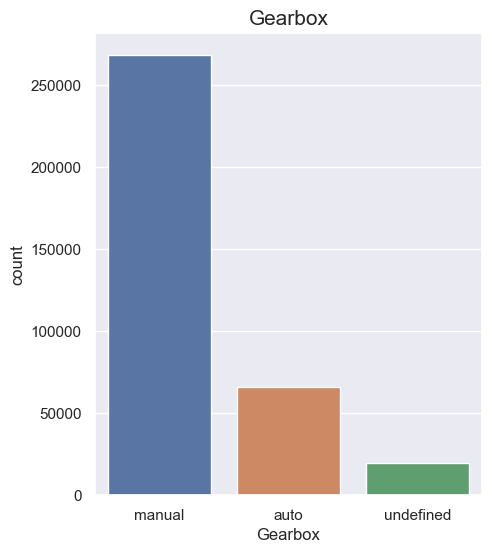

In [18]:
#тип коробки передач
sns.countplot(x=data['Gearbox'])
plt.title('Gearbox', fontsize=15)
plt.show()

- **Наиболее распространней тип трансмиссии механика, на втором месте автоматическая трансмиссия, на 3 месте пропущенные значения**

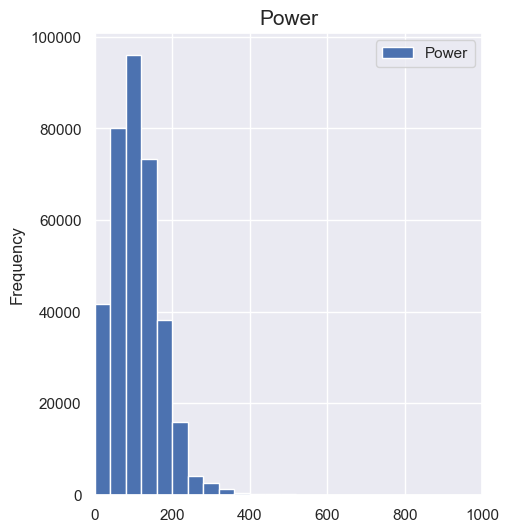

In [19]:
#посмотрим распределение мощности авто (л. с.) до 1к л.с
data['Power'].plot(kind='hist',bins=500, legend=True)
plt.xlim(0, 1000)
plt.title('Power', fontsize=15)
plt.show()

- **Смотрим распределение мощностей у автомобилей от 0 до 1.000 л.с, явный пик около 150 так же достаточно много значений около 0, их нужно будет проверить, основная часть значений находится в диапазоне до 250**

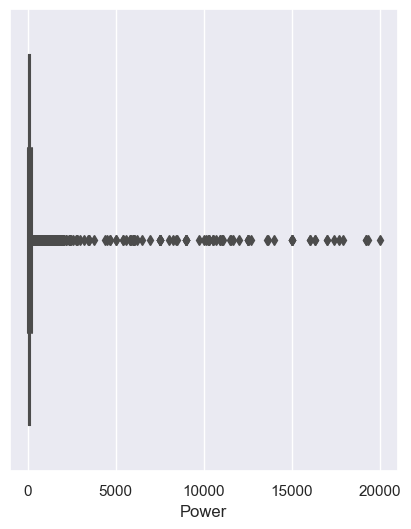

In [20]:
sns.boxplot(x=data['Power']) #.plot(kind='line', legend=True)
#plt.xticks(rotation=45)
plt.show()

- **На диаграмме размаха видно что присутствуют аномальные значения в признаке мощности до 20 тыс л.с**

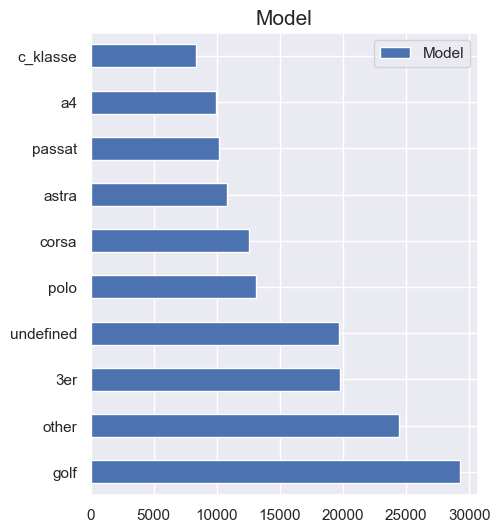

In [21]:
#10 популярных моделей
data['Model'].value_counts().head(10).plot(kind='barh',legend=True)
plt.title('Model', fontsize=15)
plt.show()

- **Смотрим 10 популярных моделей, первое место golf, категории other - скорее всего клиент не смог найти модель своего автомобиля т.к достаточно таких клиентов можно подумать над этим моментом, категория undefined - пропущенные значения и их тоже достаточно много, с этим тоже нужно что-то делать, это полезная информация при настройке модели и нужно искать причину появления пропусков**

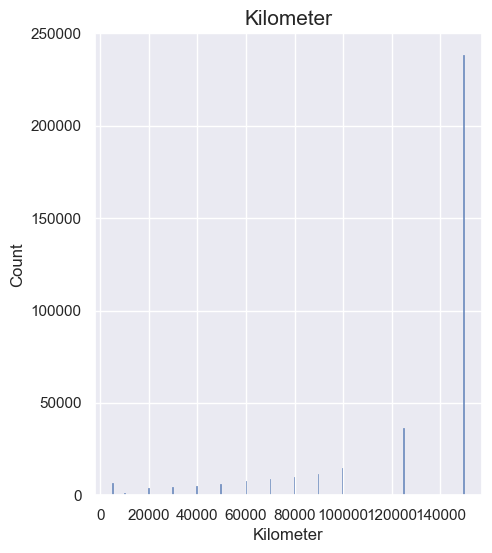

In [22]:
#посмотрим пробег авто
sns.histplot(data['Kilometer'])
plt.title('Kilometer', fontsize=15)
plt.show()

- **Смотрим распределение пробега на автомобилях, если я правильно понял то это биноминальное распределение, ничего странного здесь не вижу, можно выделить что больше всего авто с пробегом 150к км**

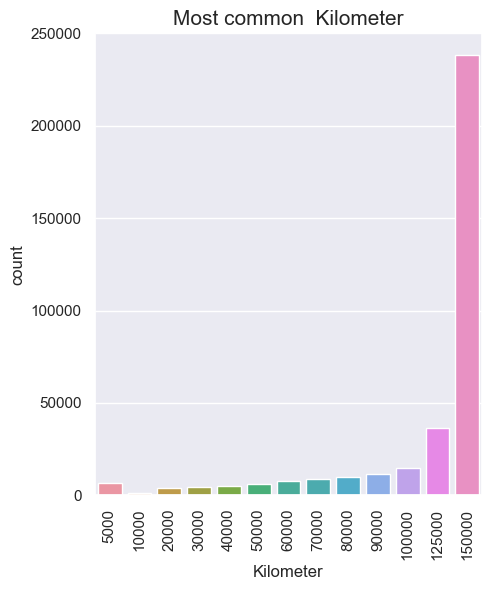

In [23]:
#смотрим с каким пробегом встречаются авто чаще
sns.countplot(x=data['Kilometer'])
plt.title('Most common  Kilometer', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [24]:
data['Kilometer'].value_counts()

150000    238207
125000     36453
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3974
10000       1222
Name: Kilometer, dtype: int64

- **Можно предположить почему продают на 5к км +- год владения - не понравилось авто, мало продают на пробеге 10к - удовлетворены автомобилем, и чем старше авто тем больше продают**

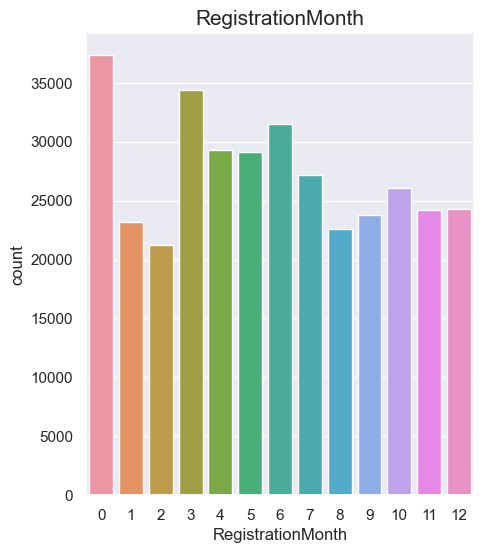

In [25]:
#месяц регистрации автомобиля
sns.countplot(x=data['RegistrationMonth'])
plt.title('RegistrationMonth', fontsize=15)
plt.show()

- **Смотрим месяц регистрации авто, этот признак особо информации не несет в отличии от года регистрации, поэтому не будем на нем останавливаться, если только выделить один лишний месяц или 0 или 12, если 0 - январь**

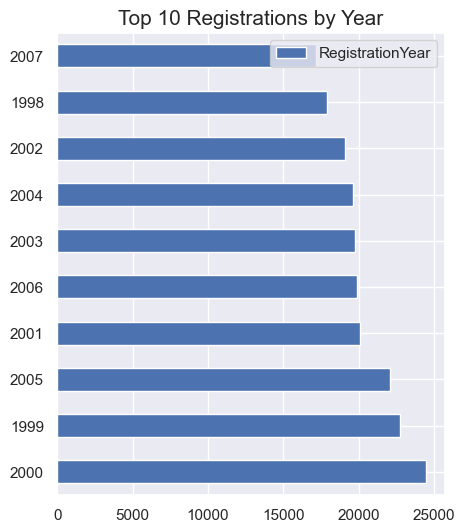

In [26]:
#год регистрации автомобиля
data['RegistrationYear'].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',legend=True)
plt.title('Top 10 Registrations by Year', fontsize=15)
plt.show()

- **Топ 10 регистраций по годам, можно сказать что больше всего авто зарегестрировано в 2000 году, меньше всего в 2007**

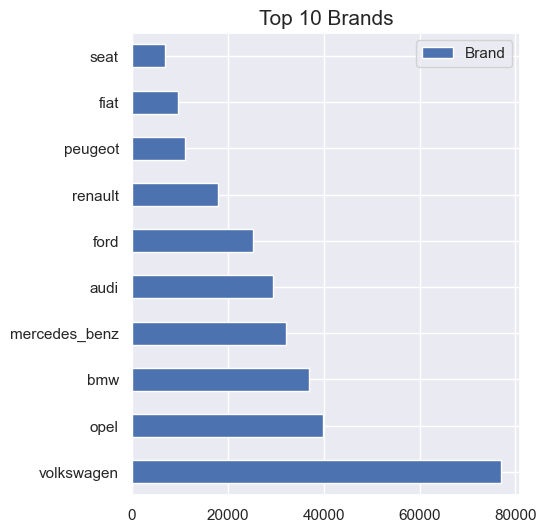

In [27]:
#популярные марки авто
data['Brand'].value_counts().sort_values(ascending=False).head(10).plot(kind='barh',legend=True)
plt.title('Top 10 Brands', fontsize=15)
plt.show()

- **Смотрим какой производитель самый популярный в сервисе, собирая все вместе можно сказать больше всего продают автомобилей фольксваген гольф, первый топ 5 это немецкие производители**

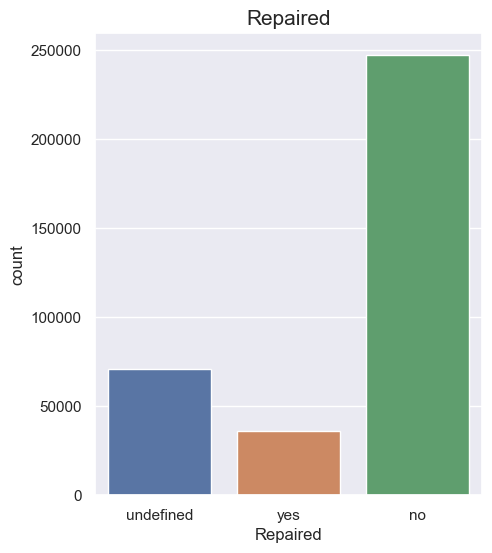

In [28]:
#была машина в ремонте или нет
sns.countplot(x=data['Repaired'])
plt.title('Repaired', fontsize=15)
plt.show()

- **Смотрим был ли автомобиль в ремонте, скорей всего аналог битый не битый, больше всего автомобилей не биты, так же присутсвует достаточное кол-во пропущенных значений, а это важный признак при определении стоимости авто**

In [29]:
data['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

In [30]:
len(data)

354365

- **Ни у одного автомобиля нет фотографий, скорее всего проблема при скачивании данных, но получился нулевой признак, далее мы его удалим**

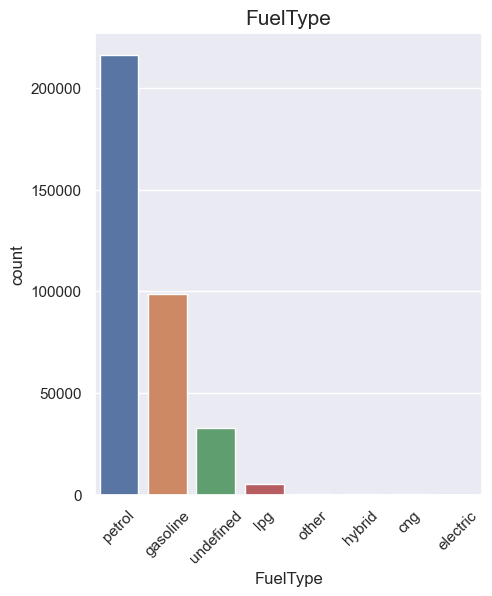

In [31]:
#тип двигателя
sns.countplot(x=data['FuelType'])
plt.title('FuelType', fontsize=15)
plt.xticks(rotation=45)
plt.show()

- **Смотрим тип двигателей у автомобилей, будем считать что petrol - бензин, gasoline - газ, тоже важный признак и лучше уточнить у зказчика так ли это, самый распространенный тип - бензиноывый, второе место gasoline, на 3 пропущенные значения, на 4 сжиженый газ или lpg, очень мало продается гибридных, на газе cng и электрокаров, т.к этих значений мало приведем их к одной категории 'other'**

In [32]:
#тип топлива
data['FuelType'].value_counts()

petrol       216349
gasoline      98719
undefined     32895
lpg            5310
cng             565
hybrid          233
other           204
electric         90
Name: FuelType, dtype: int64

In [33]:
#приведем к одной категории
data.loc[data['FuelType'] == 'cng', 'FuelType'] = 'other'
data.loc[data['FuelType'] == 'hybrid', 'FuelType'] = 'other'
data.loc[data['FuelType'] == 'electric', 'FuelType'] = 'other'

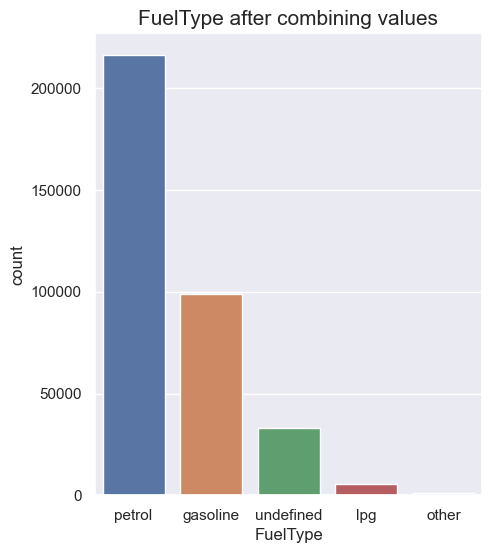

In [34]:
#тип топлива
sns.countplot(x=data['FuelType'])
plt.title('FuelType after combining values', fontsize=15)
plt.show()

- **По итогу получили 4 категории, petrol, gasoline, lpg, other, и категория пропущенных значений**

In [35]:
#почтовый индекс
data['PostalCode'].head()

0    70435
1    66954
2    90480
3    91074
4    60437
Name: PostalCode, dtype: int64

In [36]:
#дата последней активности
data['LastSeen']

0         2016-04-07 03:16:57
1         2016-04-07 01:46:50
2         2016-04-05 12:47:46
3         2016-03-17 17:40:17
4         2016-04-06 10:17:21
                 ...         
354360    2016-03-21 10:42:49
354361    2016-04-06 00:46:52
354362    2016-03-11 18:17:12
354363    2016-04-07 07:15:26
354364    2016-03-24 12:45:21
Name: LastSeen, Length: 354365, dtype: object

- **Удалим признаки почтовый индекс и дату последней активности пользователя, т.к они не несут больше смысла для модели**

In [37]:
# удалим следующие столбцы
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 
                          'DateCreated', 'NumberOfPictures',
                         'PostalCode', 'LastSeen'])

In [38]:
#проверим
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

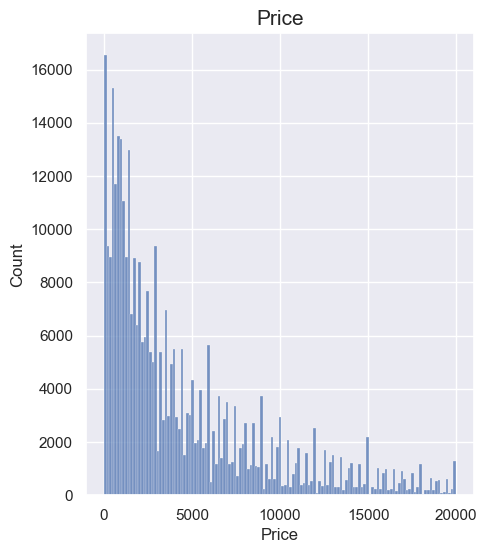

In [39]:
#распределение целеваого признака
sns.histplot(x=data['Price'])
plt.title('Price', fontsize=15)
plt.show()

- **Смотрим распределение целевого признака, похоже на логнормальное распределение если я правильно понял. Всплеск значений около 0, скорее всего проблема с данными, других тенденций выделить не могу**

****

# 2.1 Sanity check

In [40]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [41]:
#бесплатные автомобили
data[data['Price'] <= 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,undefined,1990,undefined,0,corsa,150000,petrol,opel,undefined
111,0,undefined,2017,manual,0,golf,5000,petrol,volkswagen,undefined
115,0,small,1999,undefined,0,undefined,5000,petrol,volkswagen,undefined
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354201,0,undefined,2000,manual,65,corsa,150000,undefined,opel,yes
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,undefined
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,undefined
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [42]:
#проверим еще меньше 100 евро
data[data['Price'] <= 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,undefined,1990,undefined,0,corsa,150000,petrol,opel,undefined
59,1,suv,1994,manual,286,undefined,150000,undefined,sonstige_autos,undefined
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,0,undefined,2017,manual,0,golf,5000,petrol,volkswagen,undefined
...,...,...,...,...,...,...,...,...,...,...
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,undefined
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,undefined
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354305,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


In [43]:
#самые дорогие авто 20к евро
data[data['Price'] == data['Price'].max()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1515,20000,sedan,2010,auto,239,a6,150000,gasoline,audi,no
1586,20000,sedan,2014,auto,184,leon,40000,gasoline,seat,no
2128,20000,sedan,2014,manual,135,ceed,30000,petrol,kia,no
3728,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
6286,20000,sedan,2009,auto,272,e_klasse,150000,gasoline,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...,...
342299,20000,sedan,2013,manual,194,insignia,60000,gasoline,opel,no
346161,20000,undefined,2016,auto,507,m_reihe,150000,undefined,bmw,undefined
348204,20000,sedan,2011,auto,241,lancer,40000,petrol,mitsubishi,no
349226,20000,bus,2008,auto,204,viano,125000,gasoline,mercedes_benz,no


In [44]:
#например возьмем марку гольф и среднюю цену
data[data['Model'] == 'golf']['Price'].mean()

4154.306855500821

In [45]:
# среднее по категории для цены
for d in data['Model'].unique():
    data.loc[(data['Model'] == d) & (data['Price'] <= 100), 'Price'] = \
    data.loc[(data['Model'] == d), 'Price'].mean()

In [46]:
#бесплатные автомобили теперь имеют цену
data[data['Price'] <= 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [47]:
#проверим
data[data['Model'] == 'golf']['Price'].mean()

4330.061388232756

In [48]:
#тоже считаю странным
data[data['Power'] <= 30]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480.000000,undefined,1993,manual,0,golf,150000,petrol,volkswagen,undefined
15,450.000000,small,1910,undefined,0,ka,5000,petrol,ford,undefined
32,245.000000,sedan,1994,undefined,0,golf,150000,petrol,volkswagen,no
37,1500.000000,undefined,2016,undefined,0,kangoo,150000,gasoline,renault,no
40,1892.173270,undefined,1990,undefined,0,corsa,150000,petrol,opel,undefined
...,...,...,...,...,...,...,...,...,...,...
354342,2600.000000,undefined,2005,auto,0,c_klasse,150000,undefined,mercedes_benz,undefined
354356,3999.000000,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354359,1150.000000,bus,2000,manual,0,zafira,150000,petrol,opel,no
354360,2360.266974,undefined,2005,manual,0,colt,150000,petrol,mitsubishi,yes


In [49]:
#группируем и смотрим среднюю мощность
data.groupby('Model')['Power'].mean().sort_values(ascending=False)

Model
cayenne               328.883621
m_reihe               308.780303
range_rover_evoque    296.000000
6er                   269.679487
a8                    257.773157
                         ...    
move                   42.350000
kaefer                 35.149321
samara                 26.230769
601                    15.844869
serie_1                 0.000000
Name: Power, Length: 251, dtype: float64

In [50]:
# среднее по категории для мощности
for d in data['Model'].unique():
    data.loc[(data['Model'] == d) & (data['Power'] <= 30), 'Power'] = \
    data.loc[(data['Model'] == d), 'Power'].mean()

In [51]:
#проверим
data[data['Power'] <= 30]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3338,199.000000,undefined,1995,manual,26.230769,samara,100000,petrol,lada,undefined
3419,2300.000000,undefined,2017,manual,15.844869,601,70000,undefined,trabant,no
3614,1617.133652,wagon,1988,undefined,15.844869,601,80000,undefined,trabant,undefined
5676,650.000000,sedan,1985,manual,15.844869,601,30000,petrol,trabant,yes
5770,10000.000000,undefined,1980,manual,15.844869,601,40000,undefined,trabant,no
...,...,...,...,...,...,...,...,...,...,...
349684,1617.133652,undefined,1960,undefined,15.844869,601,5000,undefined,trabant,undefined
351106,1617.133652,undefined,1990,undefined,15.844869,601,100000,undefined,trabant,undefined
353036,10000.000000,other,1988,manual,15.844869,601,5000,petrol,trabant,undefined
353551,2199.000000,undefined,2016,manual,26.230769,samara,70000,undefined,lada,no


- **Скорее всего у этих авто небольшие мощности, отсюда и среднее менее 30**

In [52]:
#исправим, поставим минимальную от 30 л.с
data = data[data['Power'] >= 30]

In [53]:
#проверим
data[data['Power'] <= 30]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [54]:
#смотрим максимальную мощность авто
data[data['Power'] == data['Power'].max()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
219583,4300.0,coupe,1999,auto,20000.0,clk,150000,petrol,mercedes_benz,no


In [55]:
#посмотрим кол-во авто с мощностью от 500 л.с
data[data['Power'] >= 500]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200.000000,small,2004,manual,1398.0,corolla,5000,petrol,toyota,no
2102,1687.486601,sedan,1999,undefined,1799.0,vectra,150000,petrol,opel,yes
3746,2927.355037,undefined,2017,manual,750.0,undefined,150000,petrol,smart,no
4060,3100.000000,sedan,2005,manual,953.0,colt,150000,gasoline,mitsubishi,no
4310,6375.408236,sedan,2007,manual,500.0,5er,100000,undefined,bmw,no
...,...,...,...,...,...,...,...,...,...,...
348964,250.000000,small,1999,manual,1241.0,ypsilon,150000,petrol,lancia,yes
351943,1500.000000,bus,2001,manual,1001.0,zafira,5000,gasoline,opel,no
353489,12500.000000,undefined,2017,manual,2000.0,other,60000,gasoline,chrysler,no
353629,2400.000000,sedan,2007,manual,650.0,c2,150000,petrol,citroen,undefined


In [56]:
#посмотрим год регистрации авто
data['RegistrationYear'].value_counts()

2000    24489
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: RegistrationYear, Length: 151, dtype: int64

In [57]:
#посмотрим корреляцию года регистрации и цены
data['RegistrationYear'].corr(data['Price'])

0.030244321822678652

- **Очень слабая положительная корреляция между ценой и годом регистрации, интуитивно понятно что чем старее автомобиль тем дешевле**

In [58]:
#оставляем год который встречается более 100 раз
year_interval = []
for (i,j) in data['RegistrationYear'].value_counts().to_dict().items():
    if j > 100:
        year_interval.append(i)

In [59]:
#проверим первые 10
sorted(year_interval)[:10]

[1910, 1960, 1966, 1968, 1969, 1970, 1971, 1972, 1973, 1974]

In [60]:
#сделаем срез по году т.к максимальная дата создания 2016, добавим условие
data = data.query('RegistrationYear in @year_interval & RegistrationYear <= 2016')

In [61]:
#проверим
data['RegistrationYear'].value_counts()

2000    24489
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17181
2008    15391
1997    14665
2009    14503
1996    10835
2010    10764
2011     9909
1995     9603
2016     9594
2012     7178
1994     4841
2013     4131
1993     3438
1992     3000
1991     2761
1990     2741
2014     2537
2015     1301
1989     1250
1988      898
1985      730
1987      639
1980      570
1986      505
1983      416
1984      387
1970      314
1982      304
1978      282
1979      280
1981      257
1972      209
1960      186
1977      170
1973      169
1976      169
1974      168
1971      164
1975      138
1969      116
1966      109
1968      105
1910      101
Name: RegistrationYear, dtype: int64

In [62]:
#проверим корреляцию
data['RegistrationYear'].corr(data['Price'])

0.44999942603152443

**Вывод**
- Проверили данные на адекватность, много аномалий, например автомобили с ценой 0 или мощностью 0, исправили это
- Исправили год регистрации автомобиля, самым старым авто 110 лет, что представляется возможным, корреляция увеличилась с 3% до 38%, признак стал более полезным для модели.

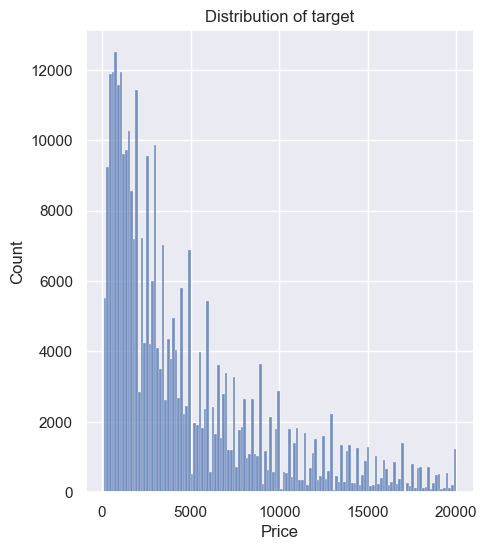

In [63]:
#распределение целеваого признака
sns.histplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

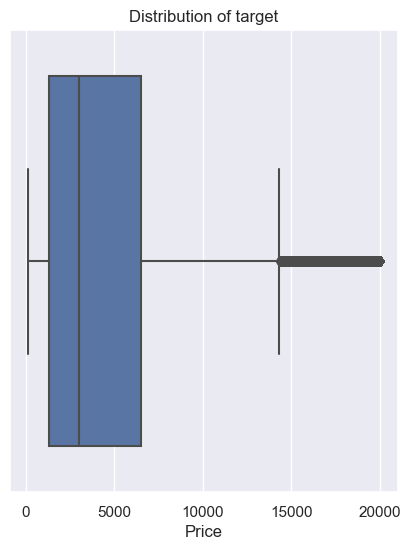

In [64]:
#распределение через диаграмму размаха
sns.boxplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

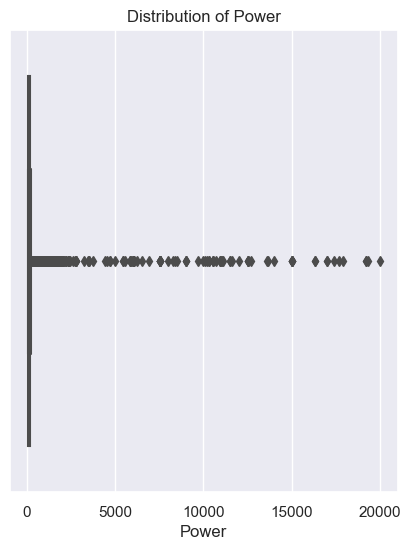

In [65]:
#посмотрим через диаграмму размаха
sns.boxplot(x=data['Power'])
plt.title('Distribution of Power')
plt.show()

- **Как уже заметили на проверке данных на адекватность, присутствуют аномалии, которые сейчас постараемся исправить**

In [66]:
#функция удалит выбросы
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    Q3, Q1 = np.nanpercentile(data[column], [75, 25])
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    data = data[(data[column] < upper_bound) & (data[column] > lower_bound)]
    
    return data

In [67]:
#применим для цены и мощности
data = remove_outliers(data, 'Price')
data = remove_outliers(data, 'Power')

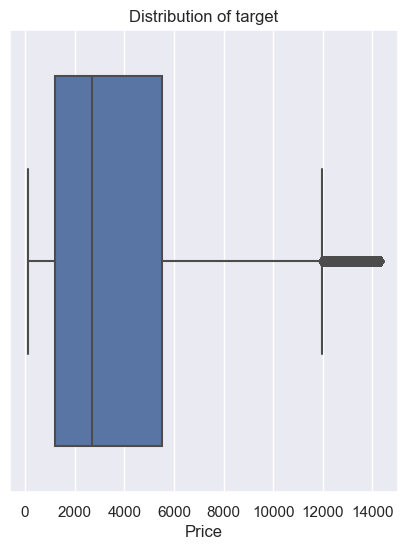

In [68]:
#проверим
sns.boxplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

In [69]:
#видно что еще остались выбросы
data = remove_outliers(data, 'Price')

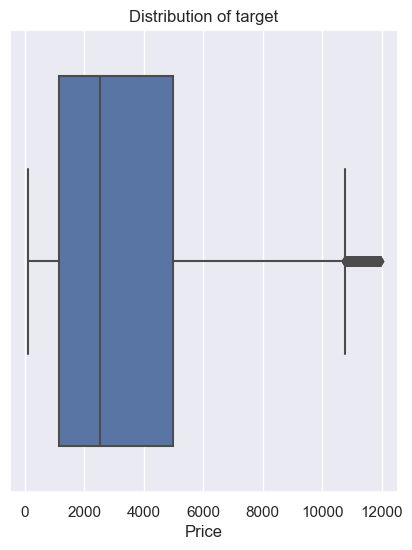

In [70]:
#проверим
sns.boxplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

In [71]:
data['Price'].min()

101.0

In [72]:
#попробуем еще убрать выбросы
data = data[data['Price'] <= 11000]

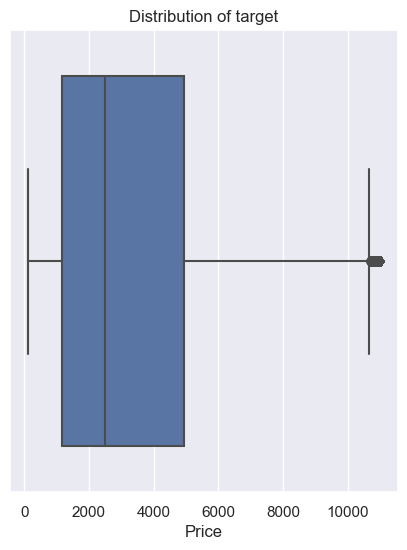

In [73]:
#проверим
sns.boxplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

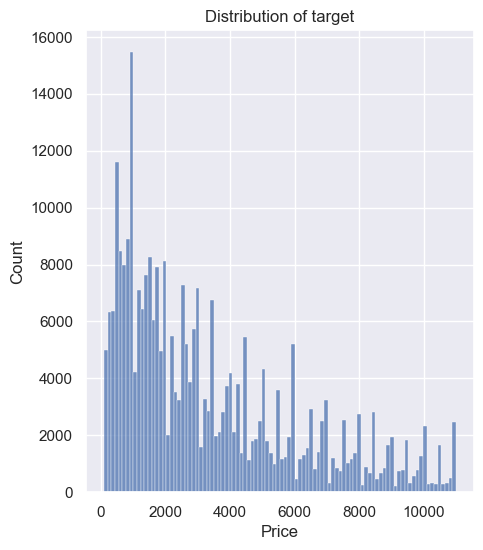

In [74]:
sns.histplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

In [75]:
#поставим цену от 500 евро
data = data[data['Price'] >= 500]

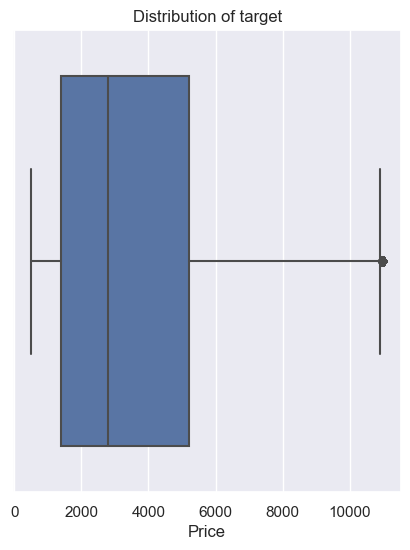

In [76]:
#проверим
sns.boxplot(x=data['Price'])
plt.title('Distribution of target')
plt.show()

- **Убрали большую часть выбросов в целевом признаке, так же убрали авто с ценами менее 500 евро, т.к все таки автомобиль не может стоить мало, или это ошибка при сборе данных в любом случае пользы от этого для модели нет**

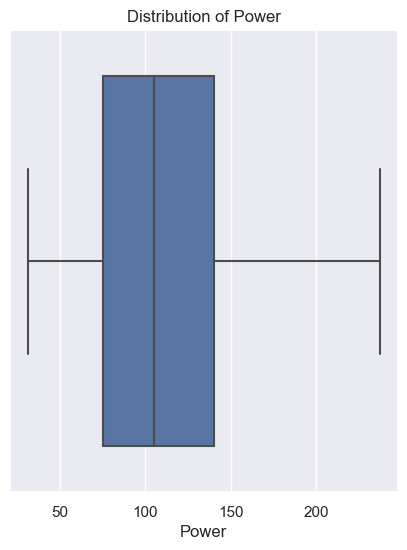

In [77]:
#посмотрим через диаграмму размаха
sns.boxplot(x=data['Power'])
plt.title('Distribution of Power')
plt.show()

In [78]:
#размер после преобразований
data.shape

(277089, 10)

In [79]:
#проверим дубликаты
data.duplicated().sum()

39049

In [80]:
#удалим дубликаты пересбросим индексы
data = data.drop_duplicates().reset_index(drop=True)

In [81]:
#проверим
data.duplicated().sum()

0

In [82]:
#размер после
data.shape

(238040, 10)

**Вывод**
- Убрали выбросы из целевого признака и мощности, не стали полностью убирать выбросы из стоимости авто, т.к если полностью убрать получатся 'идеальные' данные, и если модель сталкнется с объектом которого ранее не видела может быть некорректный прогноз стоимости

****

# 3. Порядковое кодирование и стандартизация

In [83]:
#категориальные столбцы
CAT_COLS = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [84]:
data.dtypes

Price               float64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power               float64
Model                object
Kilometer             int64
FuelType             object
Brand                object
Repaired             object
dtype: object

In [85]:
#заменим на тип категория для градиентных моделей
for column in CAT_COLS:
    data[column] = data[column].astype('category')

In [86]:
data.dtypes

Price                float64
VehicleType         category
RegistrationYear       int64
Gearbox             category
Power                float64
Model               category
Kilometer              int64
FuelType            category
Brand               category
Repaired            category
dtype: object

In [87]:
#разделим на признаки и целевой
X_gradient = data.drop(columns = 'Price', axis=1)
y_gradient = data['Price']

In [88]:
#проверим
X_gradient.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,suv,2004,auto,163.0,grand,125000,gasoline,jeep,undefined
1,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
2,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
3,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
4,convertible,2004,manual,109.0,2_reihe,150000,petrol,peugeot,no


In [89]:
#кодируем
data = pd.get_dummies(data, drop_first=True, columns = CAT_COLS)

In [90]:
#проверим на месте ли численные признаки
'RegistrationYear' and 'Price' and 'Power' and 'Kilometer' in data.columns

True

In [91]:
#размер после кодирования
data.shape

(238040, 305)

In [92]:
#делим закодированные данные на признаки и целевой
X = data.drop(columns = 'Price', axis=1)
y = data['Price']

In [93]:
#проверим
'Price' in X.columns

False

In [94]:
#раздяляем на выборки 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=1)

#оставим категориальные для градиентных моделей
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gradient, y_gradient, test_size = 0.2, random_state=1)
X_train_g, X_valid_g, y_train_g, y_valid_g = train_test_split(X_train_g, y_train_g, test_size = 0.25, random_state=1)

In [95]:
#стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

In [96]:
#для обычных моделей
print('Обучающая выборка', X_train.shape, y_train.shape)
print('Валидационная выборка', X_valid.shape, y_valid.shape)
print('Тестовая выборка', X_test.shape, y_test.shape)

Обучающая выборка (142824, 304) (142824,)
Валидационная выборка (47608, 304) (47608,)
Тестовая выборка (47608, 304) (47608,)


In [97]:
#для бустинга
print('Обучающая выборка', X_train_g.shape, y_train_g.shape)
print('Валидационная выборка', X_valid_g.shape, y_valid_g.shape)
print('Тестовая выборка', X_test_g.shape, y_test_g.shape)

Обучающая выборка (142824, 9) (142824,)
Валидационная выборка (47608, 9) (47608,)
Тестовая выборка (47608, 9) (47608,)


In [98]:
#проверим
X_train.shape[0]/data.shape[0], X_valid.shape[0]/data.shape[0], X_test.shape[0]/data.shape[0]

(0.6, 0.2, 0.2)

**Вывод**
- Разделили данные в соотношении 60 train - 20 valid - 20 test
- Закодировали категориальные признаки методом ohe
- Привели к типу category для кодировщика в модели lgbm
- Стандартизировали данные, чтобы модель непереобучилась на большие значения

# SGDRegressor

In [99]:
#линейная регрессия обцчаемая стохастическим градиентным спуском # 
model = SGDRegressor(random_state=1, alpha=0.0001,  #epsilon=0.0001, 
                     eta0=0.0001, loss='squared_error', max_iter = 3000)

In [100]:
%%time
model.fit(X_train, y_train)

Wall time: 2min 7s


SGDRegressor(eta0=0.0001, max_iter=3000, random_state=1)

In [101]:
%%time
sgd_pred = model.predict(X_valid)

Wall time: 141 ms


In [102]:
print('SGDRegressor valid RMSE:', mean_squared_error(y_valid, sgd_pred)**0.5)

SGDRegressor valid RMSE: 1816.2366508663617


- **Получилось немного настроить**

# DecisionTreeRegressor

In [103]:
#дерво решений
tree = DecisionTreeRegressor(random_state=1, max_depth = 13)

In [104]:
#parametrs = { 
#    'criterion': ['squared_error'],
#    'max_features': ['sqrt', 'log2'],
#    'max_depth': range (1, 15), 
#    'min_samples_leaf': range (2, 25),
#    'min_samples_split': [5, 10, 35, 50, 100, 200, 250, 300, 500],
#            }

In [105]:
#grid_tree = HalvingGridSearchCV(tree, parametrs, cv=2, scoring='neg_root_mean_squared_error', verbose=10)

In [106]:
#%%time
#grid_tree.fit(X_train, y_train)

In [107]:
#grid_tree.best_params_ 

In [108]:
#best_tree = grid_tree.best_estimator_

In [109]:
#best_pred = best_tree.predict(X_valid)

In [110]:
#print('DecisionTreeRegressor RMSE:', mean_squared_error(y_valid, best_pred)**0.5)

- **Не получилось(RMSE > 2.400)подобрать гиперпараметры, с глубиной 13, дерево справляется отлично**

In [111]:
%%time
tree.fit(X_train, y_train)

Wall time: 16.8 s


DecisionTreeRegressor(max_depth=13, random_state=1)

In [112]:
%%time
tree_pred = tree.predict(X_valid)

Wall time: 236 ms


In [113]:
print('DecisionTreeRegressor valid RMSE:',mean_squared_error(y_valid, tree_pred)**0.5)

DecisionTreeRegressor valid RMSE: 1419.2323141723448


**Вывод**

In [114]:
#словарь с параметрами для lgbm
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'verbose': 0,
    'n_estimators': 10000,
    'n_jobs': -1 }

In [115]:
#создаем модель
lgbm = LGBMRegressor(random_state=1, **params, )

In [116]:
%%time
lgbm.fit(X_train_g, y_train_g,
        eval_set=[(X_valid_g, y_valid_g)],
        eval_metric='rmse')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 2705.81
[2]	valid_0's rmse: 2688.57
[3]	valid_0's rmse: 2671.54
[4]	valid_0's rmse: 2654.76
[5]	valid_0's rmse: 2638.18


C:\Users\alexa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\alexa\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[6]	valid_0's rmse: 2621.84
[7]	valid_0's rmse: 2605.43
[8]	valid_0's rmse: 2589.49
[9]	valid_0's rmse: 2573.51
[10]	valid_0's rmse: 2557.92
[11]	valid_0's rmse: 2542.4
[12]	valid_0's rmse: 2527.25
[13]	valid_0's rmse: 2512.18
[14]	valid_0's rmse: 2497.52
[15]	valid_0's rmse: 2482.62
[16]	valid_0's rmse: 2468.33
[17]	valid_0's rmse: 2454.01
[18]	valid_0's rmse: 2439.84
[19]	valid_0's rmse: 2425.89
[20]	valid_0's rmse: 2411.93
[21]	valid_0's rmse: 2398.29
[22]	valid_0's rmse: 2384.93
[23]	valid_0's rmse: 2371.65
[24]	valid_0's rmse: 2358.58
[25]	valid_0's rmse: 2345.72
[26]	valid_0's rmse: 2332.77
[27]	valid_0's rmse: 2320.22
[28]	valid_0's rmse: 2307.64
[29]	valid_0's rmse: 2295.36
[30]	valid_0's rmse: 2283.34
[31]	valid_0's rmse: 2271.32
[32]	valid_0's rmse: 2259.35
[33]	valid_0's rmse: 2247.52
[34]	valid_0's rmse: 2236.08
[35]	valid_0's rmse: 2224.81
[36]	valid_0's rmse: 2213.64
[37]	valid_0's rmse: 2202.41
[38]	valid_0's rmse: 2191.35
[39]	valid_0's rmse: 2180.63
[40]	valid_0's rmse

LGBMRegressor(learning_rate=0.01, metric='rmse', n_estimators=10000,
              objective='regression', random_state=1, task='train', verbose=0)

**Итоговой моделью предлагаю выбрать lgbm, т.к на валидационной выборке у нее самый лучший показатель, и скорость обучения-предсказания невелика**

In [117]:
%%time
lgbm_pred = lgbm.predict(X_test_g, num_iteration=lgbm.best_iteration_)

Wall time: 1min 44s


In [118]:
print('LGBMRegressor test RMSE:', mean_squared_error(y_test_g, lgbm_pred)**0.5)

LGBMRegressor test RMSE: 1204.1929513698503


**Эксперимент**

In [119]:
#попробуем настроить lgbm
from verstack import LGBMTuner

In [120]:
# tune the hyperparameters and fit the optimized model
tuner = LGBMTuner(metric = 'rmse', trials = 20)


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 20 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 1214.9318285267827
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 1217.4710178801467
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 1228.6900115834617
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 1219.2096892762806
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 1216.5462288992144
 ...............................................

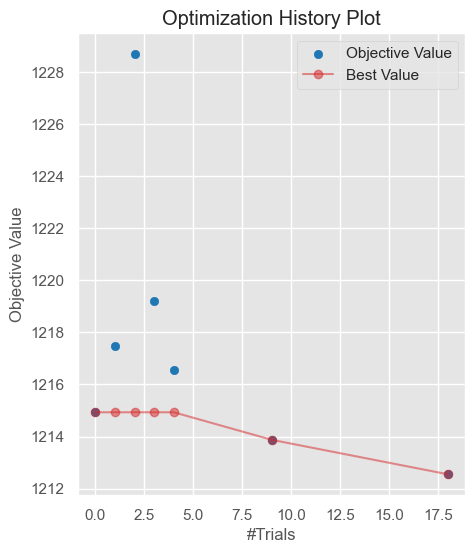

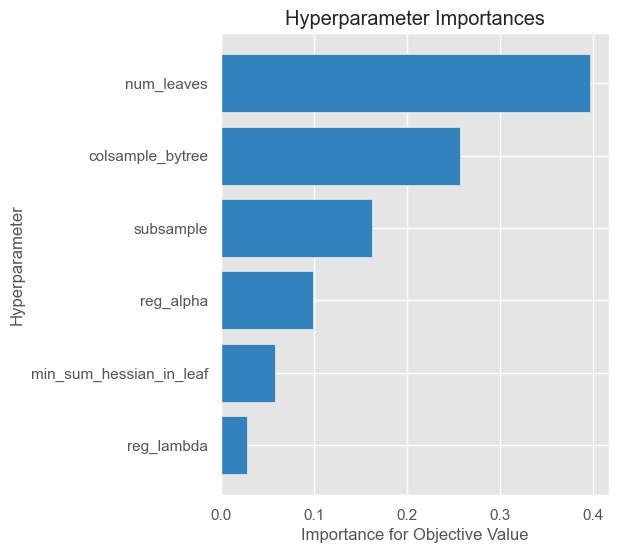

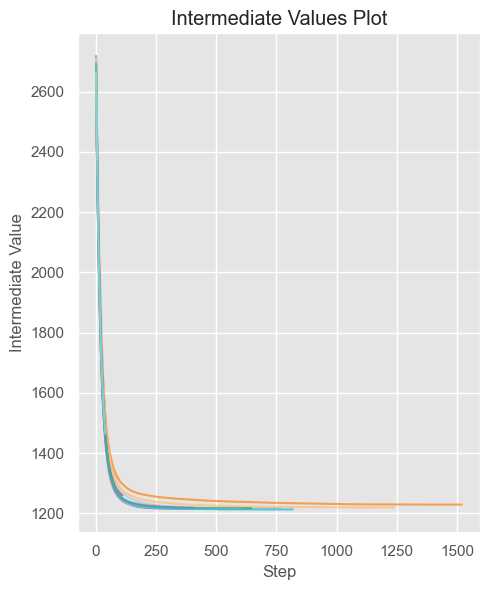

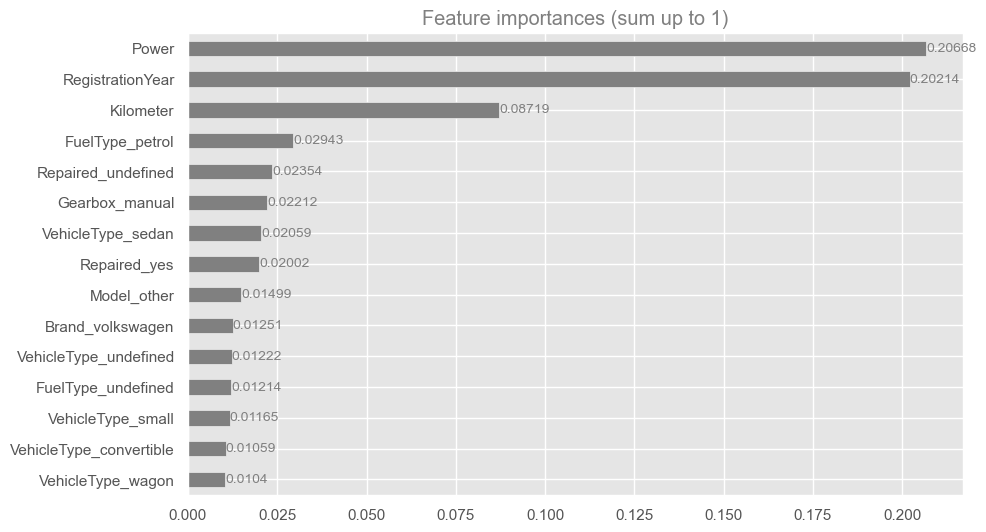


     . Optuna hyperparameters optimization finished
     .. Best trial number:18    |     rmse:            1212.549621658271
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  668   |     rmse:            1219.078546966947

Time elapsed for fit execution: 12 min 4.5 sec
Wall time: 12min 4s


In [121]:
%%time
tuner.fit(pd.DataFrame(data=X_train, columns=X.columns), y_train_g)

In [122]:
tuner_params = tuner.best_params

In [123]:
tuner_lgbm = LGBMRegressor(**tuner_params)

In [124]:
tuner_lgbm.fit(X_train_g, y_train_g,
        eval_set=[(X_valid_g, y_valid_g)],
        eval_metric='rmse')

[1]	valid_0's rmse: 2649.68
[2]	valid_0's rmse: 2576.61
[3]	valid_0's rmse: 2506.1
[4]	valid_0's rmse: 2439.88
[5]	valid_0's rmse: 2376.14
[6]	valid_0's rmse: 2314.85
[7]	valid_0's rmse: 2276.18
[8]	valid_0's rmse: 2220.11
[9]	valid_0's rmse: 2167.96
[10]	valid_0's rmse: 2117.79
[11]	valid_0's rmse: 2069.04
[12]	valid_0's rmse: 2022.99
[13]	valid_0's rmse: 1978.86
[14]	valid_0's rmse: 1946.75
[15]	valid_0's rmse: 1907.15
[16]	valid_0's rmse: 1869.16
[17]	valid_0's rmse: 1834.18
[18]	valid_0's rmse: 1800.76
[19]	valid_0's rmse: 1768.45
[20]	valid_0's rmse: 1738.46
[21]	valid_0's rmse: 1709.6
[22]	valid_0's rmse: 1682.24
[23]	valid_0's rmse: 1657
[24]	valid_0's rmse: 1632.82
[25]	valid_0's rmse: 1609.75
[26]	valid_0's rmse: 1592.04
[27]	valid_0's rmse: 1571.55
[28]	valid_0's rmse: 1555.08
[29]	valid_0's rmse: 1536.29
[30]	valid_0's rmse: 1521.65
[31]	valid_0's rmse: 1504.69
[32]	valid_0's rmse: 1488.76
[33]	valid_0's rmse: 1473.71
[34]	valid_0's rmse: 1459.68
[35]	valid_0's rmse: 1446
[3

LGBMRegressor(colsample_bytree=0.7768574475198697, device_type='cpu',
              learning_rate=0.04, metric='rmse',
              min_sum_hessian_in_leaf=0.02497827739335429, n_estimators=668,
              num_leaves=170, num_threads=2, objective='regression',
              random_state=42, reg_alpha=3.1802446249448637e-06,
              reg_lambda=0.006043082249395017, subsample=0.8552186969211897,
              verbosity=-1)

In [125]:
tuner_lgbm_pred = tuner_lgbm.predict(X_test_g)

In [126]:
print('LGBMRegressor test RMSE:', mean_squared_error(y_test_g, tuner_lgbm_pred)**0.5)

LGBMRegressor test RMSE: 1196.99009708919


### Итоговый вывод:
- Познакомились с данными, в данных много пропущенных значений и аномалий, которые постарались исправить не избавляясь от данных, провели порядковое кодирование и стандартизацию.
- Отдельно для градиентных моделей(lgbm) разделили данные на train/test т.к они умеют сами обрабатывать категориальные признаки
- Обучили модели и сделали предсказание замеры на валидационной выборке:

| | SGD   | DecisionTree    | LGBM   |
|---:|:-------------|:-----------|:------|
| **Скорость обучения** | 4 min  | 35 s | 4 min | 
| **Скорость предсказания** | 160 ms  |386 ms | 2 min|
| **Метрика - RMSE** | 1.816  | 1.419    | 1.204 | 

- **Исходя из таблицы предлагаю выбрать модель LGBM,которая показала на тесте:**
    - **RMSE: 1.204, время обучения - 4 min, время предсказания 2 min** 
- **т.к дело имеем с автомобилями разница в 200 евро уже будет ощутима в отличии например от квартир и сравнивая между очень быстрым деревом и бустингом деревьев предлагаю остановить свой выбор на LGBM т.к общее время работы 6 минут, и качество заметно выше.**